# IMDB Sentiment Classifier (Bi-directional LSTM)

#### Load dependencies

In [4]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, SpatialDropout1D, Dense
from keras.layers.wrappers import Bidirectional 
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\moi\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


sequential model = all of the layers feed sequentialy (linearly), one after the other
ModelCheckPoint: to save results from each of our epochs

#### Set Hyperparameters 

In [5]:
output_dir='model_output/biLSTM'

epochs=6 # to be sure that już się nauczył 
batch_size=128 #mini b.s. for Gradient Descent, for start

# for Vector Space Embeddings: 

n_dim=64 # number of dimensions
n_unique_words = 10000 #more efficient, more words
max_review_length =200 # in both directions
            # = instead of gradient vanishing over 100 cells 

drop_embed=0.2  # dropout into the embedding layer, to randomly dropout 20%; to avoid overfitting
pad_type=  trunc_type='pre'



#### NN architecture 


In [6]:
n_dense=256
dropout=0.2

n_lstm = 256 
drop_lstm=3  # size of the filter, 1-dimensional
            # = sequences of 3 words in a row, that can give a positive or negative sentiment


common practice in building LSTMs: 
<br>  embedding layer -> into LSTM layer -> directly into output layer<br>
it's not common to have dense layer inbetween

#### Load data 
for tokenizing: 
* set the max. number of tokens in each of documents, 
* filters out punctuation, 
* sets all tokens to lowercase, 
* converts all words into an integer index
<br>
= keras.preprocessing.text.Tokenizer

In [7]:
(X_train, y_train), (X_test, y_test) =  imdb.load_data(num_words=n_unique_words)
                                #no skipped words, they can be important)

#### Restore words from index 

In [8]:
word_index=keras.datasets.imdb.get_word_index()
word_index={k:(v+3) for k,v in word_index.items()}
word_index['PAD']=0
word_index['START']=1
word_index['UNK']=2

In [9]:
word_index={v:k for k,v in word_index.items()}
word_index[215]

'must'

In [10]:

(w_x_train,_), (w_x_valid,_)=imdb.load_data()

#### Preprocess data 
sequences longer than 100 will be truncated (at the front) to 100 tokens <br>
shorter than 100: will be padded up to 100<br>
the value for padding: 0

In [11]:
X_train=pad_sequences(X_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type)
X_test=pad_sequences(X_test, maxlen=max_review_length, padding=pad_type, truncating=trunc_type)

#### Design NN architecture

In [14]:
model=Sequential()
model.add(Embedding(n_unique_words, # creating VSE from revies, in a single step
                  n_dim, input_length=max_review_length)) #optionally pretrain the word embedding
model.add(SpatialDropout1D(drop_embed)) # dropout to the embedding layer, we drop 20% of the neurons on every step

model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm))) #!! tak wrapper dodajemy do bi
model.add(Dense(1, activation='sigmoid')) 


Text is converted into **vector space embedding**
<br>Dense layer will learn which word vector representations are predictive of whether it is a positive or negative review


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 64)           640000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 200, 64)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512)               657408    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 1,297,921
Trainable params: 1,297,921
Non-trainable params: 0
_________________________________________________________________


increased the number of parameters (more words)

#### Configure the model 

In [16]:
model.compile(
    loss='binary_crossentropy',    #loss: binary crossentropy is efficient   
    optimizer='adam',
    metrics=['accuracy'])  

In [17]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [18]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train

In [19]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/6
25000/25000 [==============================] - 1007s 40ms/step - loss: 0.5303 - acc: 0.7216 - val_loss: 0.3393 - val_acc: 0.8546
Epoch 2/6
25000/25000 [==============================] - 1095s 44ms/step - loss: 0.3097 - acc: 0.8767 - val_loss: 0.3305 - val_acc: 0.8614
Epoch 3/6
25000/25000 [==============================] - 1131s 45ms/step - loss: 0.2268 - acc: 0.9144 - val_loss: 0.3659 - val_acc: 0.8621
Epoch 4/6
25000/25000 [==============================] - 1150s 46ms/step - loss: 0.1771 - acc: 0.9340 - val_loss: 0.3779 - val_acc: 0.8496
Epoch 5/6
25000/25000 [==============================] - 1125s 45ms/step - loss: 0.1486 - acc: 0.9467 - val_loss: 0.3923 - val_acc: 0.8610
Epoch 6/6
25000/25000 [==============================] - 1262s 50ms/step - loss: 0.1247 - acc: 0.9559 - val_loss: 0.4015 - val_acc: 0.8580


#### Evaluate 

In [32]:
model.load_weights(output_dir+'/weights.02.hdf5') 

In [33]:
y_hat=model.predict_proba(X_test)

In [35]:
y_hat[1]

array([0.9566309], dtype=float32)

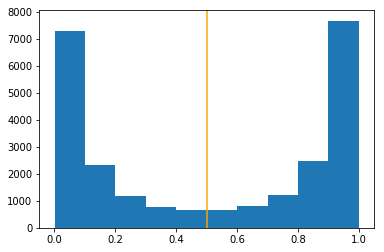

In [36]:
plt.hist(y_hat)
_=plt.axvline(x=0.5, color='orange')


In [41]:
pct_auc=roc_auc_score(y_test, y_hat)*100
print('ROC_AUC score: {:.2f} %'.format(pct_auc))

ROC_AUC score: 93.36 %


In [42]:
float_y_hat=[]
for i in y_hat:
    float_y_hat.append(i[0])

In [43]:
a=list(y_hat)

In [44]:
ydf=pd.DataFrame(list(zip(float_y_hat, y_test)), columns=['y_hat', 'y'])

In [45]:
ydf.head(20)

,y_hat,y
0,0.241943,0
1,0.956631,1
2,0.692140,1
3,0.178314,0
4,0.981488,1
5,0.731879,1
6,0.865178,1
7,0.033390,0
8,0.894709,0
9,0.841857,1


look at  the most positive review:

In [46]:
' '.join(word_index[id] for id in w_x_valid[16])

"START from 1996 first i watched this movie i feel never reach the end of my satisfaction i feel that i want to watch more and more until now my god i don't believe it was ten years ago and i can believe that i almost remember every word of the dialogues i love this movie and i love this novel absolutely perfection i love willem defoe he has a strange voice to spell the words black night and i always say it for many times never being bored i love the music of it's so much made me come into another world deep in my heart anyone can feel what i feel and anyone could make the movie like this i don't believe so thanks thanks"

identify why wrong prediction was wrong:

In [47]:
wrongs=ydf[(ydf.y==0)&(ydf.y_hat>0.9)]

In [48]:
len(wrongs)

402

In [49]:
wrongs.head()

,y_hat,y
75,0.946915,0
247,0.956947,0
256,0.941300,0
299,0.960442,0
376,0.963078,0


In [51]:
' '.join(word_index[id] for id in w_x_valid[299])

"START it's exactly what the title tells you an island inhabited by shipwrecked doctor claudio cassinelli and crew land on the island they're either picked off by the or roped into working for treasure hunting lunatic richard johnson cassinelli discovers that johnson who believes he's found the lost city of atlantis has been keeping disgraced scientist joseph cotten and his daughter barbara bach hostage for 15 years so the can uncover a treasure trove beneath the sea cotten of course is a complete madman bach and cassinelli have great chemistry this insanity was directed by sergio martino and is not surprisingly without merit it's fast paced reasonably well acted and the look pretty convincing though it's unlikely anyone could prove that these things don't look like actual there's an excellent music score by luciano"

In [52]:
fp=ydf[(ydf.y==1)&(ydf.y_hat<0.1)]

In [53]:
len(fp)

278

In [54]:
fp.head()

,y_hat,y
101,0.057460,1
167,0.077510,1
298,0.090202,1
333,0.071497,1
345,0.068017,1


In [55]:
' '.join(word_index[id] for id in w_x_valid[101])

"START okul is the first of its kind in turkish cinema and it's way better than i expected those people who say it's neither scary nor funny have a point it's not all that great indeed but it must be kept in mind that everyone involved with the movie is rather amateur so it's basically a maiden voyage and comparing this one to other films such as the 1st class garbage propaganda this movie is pretty damn good br br one thing that must be said it deals with the highschool students' life in turkey very realistically that's exactly how it goes the scenes that are meant to scare are somewhat cheap and hollywoodish most of them even if not all but that religion lesson scene made me laugh in tears and performs the best acting of this flick as a religion teacher br br it's not a waste of your time go and watch it you'll find it rather amusing especially if you know turkey enough to relate to turkish school lives"

The model is oversimplified.